# Fine-tuning a Vision Transformer Model with a Custom Biomedical Dataset

In this example, we will fine-tune a Vision Transformer (ViT) model on a custom biomedical dataset.

The model we fine-tune will be Google's [`vit-large-patch16-224`](https://huggingface.co/google/vit-large-patch16-224), which is trained on ImageNet-21k and fine-tuned on ImageNet 0212 at resolution 224x224.

## Setups

In [ ]:
!pip install -qU datasets transformers accelerate torch torchvision scikit-learn matplotlib wandb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.7/354.7 kB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 42.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 30.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 86.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## Dataset preparation

In [ ]:
from datasets import load_dataset, DatasetDict

dataset = load_dataset('emre570/breastcancer-ultrasound-images')

README.md:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/212M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/53.6M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/624 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/156 [00:00<?, ? examples/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 624
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 156
    })
})

In [ ]:
test_num = len(dataset['test'])
train_num = len(dataset['train'])

val_size = test_num / train_num

train_val_split = dataset['train'].train_test_split(test_size=val_size)
train_val_split

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 468
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 156
    })
})

In [ ]:
dataset = DatasetDict(
    {
        'train': train_val_split['train'],
        'validation': train_val_split['test'],
        'test': dataset['test']
    }
)
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 468
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 156
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 156
    })
})

In [ ]:
train_ds = dataset['train']
val_ds = dataset['validation']
test_ds = dataset['test']

In [ ]:
train_ds[0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=567x471>,
 'label': 0}

The image is a `PIL.Image` with a label associated with it.

In [ ]:
train_ds.features

{'image': Image(mode=None, decode=True, id=None),
 'label': ClassLabel(names=['benign', 'malignant', 'normal'], id=None)}

We can show one image from each class from dataset.

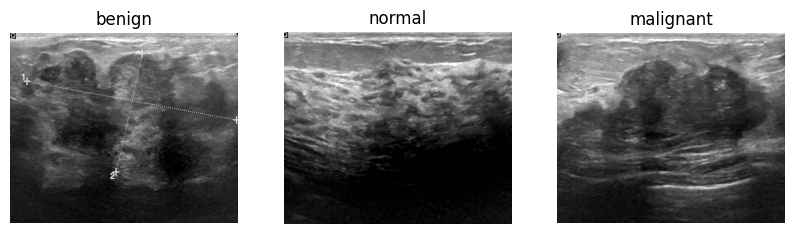

In [ ]:
import matplotlib.pyplot as plt

# initialize a set to keep track of shown labels
shown_labels = set()

plt.figure(figsize=(10, 10))

# loop through the dataset and plot the first image of each label
for i, sample in enumerate(train_ds):
    label = train_ds.features['label'].names[sample['label']]
    if label not in shown_labels:
        plt.subplot(1, len(train_ds.features['label'].names), len(shown_labels)+1)
        plt.imshow(sample['image'])
        plt.title(label)
        plt.axis('off')
        shown_labels.add(label)

        if len(shown_labels) == len(train_ds.features['label'].names):
            break

plt.show()

## Data processing

While the dataset is ready, we still need to do some preprocessing work:
- **Label mapping**: We convert between label IDs and their corresponding names, useful for model training and evaluation.
- **Image processing**: We then utilize the `ViTImageProcessor` to standardize input image sizes and applies normalization specific to the pretrained model. Also, we will define different transformations for training, validation, and test to improve model generalization using `torchvision`.
- **Transform functions**: We implement functions to apply the transformations to the dataset, converting images to the required format and dimensions for the ViT model.
- **Data loading**: We set up a custom collate function to properly batch images and labels, and create a `DataLoader` for efficient loading and batching during model training.
- **Batch preparation**: We retrieve and display the shape of data in a sample batch to verify correct processing and readiness for model input.

### Label mapping

In [ ]:
id2label = {
    id: label for id, label in enumerate(train_ds.features['label'].names)
}

label2id = {
    label: id for id, label in id2label.items()
}

id2label, id2label[train_ds[0]['label']]

({0: 'benign', 1: 'malignant', 2: 'normal'}, 'benign')

### Image processing

In [ ]:
from transformers import ViTImageProcessor

model_name = 'google/vit-large-patch16-224'
processor = ViTImageProcessor.from_pretrained(model_name)

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [ ]:
from torchvision.transforms import CenterCrop, Compose, Normalize, RandomHorizontalFlip, RandomResizedCrop, ToTensor, Resize

image_mean = processor.image_mean
image_std = processor.image_std
size = processor.size['height']

normalize = Normalize(mean=image_mean, std=image_std)

train_transforms = Compose([
    RandomResizedCrop(size),
    RandomHorizontalFlip(),
    ToTensor(),
    normalize
])

val_transforms = Compose([
    Resize(size),
    CenterCrop(size),
    ToTensor(),
    normalize
])

test_transforms = Compose([
    Resize(size),
    CenterCrop(size),
    ToTensor(),
    normalize
])

### Create transform functions

In [ ]:
def apply_train_transforms(examples):
    examples['pixel_values'] = [
        train_transforms(image.convert('RGB')) for image in examples['image']
    ]
    return examples

def apply_val_transforms(examples):
    examples['pixel_values'] = [
        val_transforms(image.convert('RGB')) for image in examples['image']
    ]
    return examples

def apply_test_transforms(examples):
    examples['pixel_values'] = [
        test_transforms(image.convert('RGB')) for image in examples['image']
    ]
    return examples

### Apply transform functions to each set

In [ ]:
train_ds.set_transform(apply_train_transforms)
val_ds.set_transform(apply_val_transforms)
test_ds.set_transform(apply_test_transforms)

In [ ]:
train_ds.features

{'image': Image(mode=None, decode=True, id=None),
 'label': ClassLabel(names=['benign', 'malignant', 'normal'], id=None)}

In [ ]:
train_ds[0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=567x471>,
 'label': 0,
 'pixel_values': tensor([[[-0.1608, -0.1765, -0.2000,  ..., -0.3725, -0.3647, -0.3490],
          [-0.1922, -0.1765, -0.1765,  ..., -0.3725, -0.3490, -0.3176],
          [-0.2392, -0.2314, -0.2157,  ..., -0.4118, -0.3804, -0.3490],
          ...,
          [-0.2627, -0.2784, -0.2784,  ..., -0.7569, -0.7647, -0.7725],
          [-0.3020, -0.3176, -0.3098,  ..., -0.6784, -0.6863, -0.6863],
          [-0.3725, -0.3725, -0.3647,  ..., -0.6471, -0.6314, -0.6157]],
 
         [[-0.1608, -0.1765, -0.2000,  ..., -0.3725, -0.3647, -0.3490],
          [-0.1922, -0.1765, -0.1765,  ..., -0.3725, -0.3490, -0.3176],
          [-0.2392, -0.2314, -0.2157,  ..., -0.4118, -0.3804, -0.3490],
          ...,
          [-0.2627, -0.2784, -0.2784,  ..., -0.7569, -0.7647, -0.7725],
          [-0.3020, -0.3176, -0.3098,  ..., -0.6784, -0.6863, -0.6863],
          [-0.3725, -0.3725, -0.3647,  ..., -0.6471, -0.6314, -0.6157]],


Now we have a new column `pixel_values` stored as tensors.

### Data loading

In [ ]:
import torch
from torch.utils.data import DataLoader


def collate_fn(examples):
    pixel_values = torch.stack([example['pixel_values'] for example in examples])
    labels = torch.tensor([example['label'] for example in examples])

    return {'pixel_values': pixel_values, 'labels': labels}

In [ ]:
train_dl = DataLoader(
    train_ds,
    collate_fn=collate_fn,
    batch_size=4
)

### Batch preparation

In [ ]:
batch = next(iter(train_dl))

for k, v in batch.items():
    if isinstance(v, torch.Tensor):
        print(k, v.shape)

pixel_values torch.Size([4, 3, 224, 224])
labels torch.Size([4])


## Fine-tuning the model

First, we call our model.

In [ ]:
from transformers import ViTForImageClassification

model = ViTForImageClassification.from_pretrained(
    model_name,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
)

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-large-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 1024]) in the checkpoint and torch.Size([3, 1024]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


When we fine-tune a pretrained model on a new dataset, sometimes the input size of our images or the model architecture specifics (like the number of labels inthe classification layer) may not match exactly with what the model was originally trained on. Setting `ignore_mismatched_sizes = True` allows the model to adjust its layers to accommodate size differences without throwing an error.

For example, the number of classes this model is trained on is 1000, which is `torch.Size([1000])`, and it expects an input with `torch.Size([1000])` classes. Our dataset has 3, which is `torch.Size([3])` classes. If we give it directly, it will raise an error because the class numbers do not match.

Then we will define training arguments for this model.

In [ ]:
from transformers import TrainingArguments, Trainer
import numpy as np

training_args = TrainingArguments(
    output_dir='output-models',
    save_total_limit=2,
    report_to='wandb',
    save_strategy='epoch',
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=10,
    per_device_eval_batch_size=4,
    num_train_epochs=40,
    weight_decay=0.01,
    load_best_model_at_end=True,
    logging_dir='logs',
    remove_unused_columns=False
)

In [ ]:
trainer = Trainer(
    model,
    training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=collate_fn,
    tokenizer=processor
)

<ipython-input-26-37bb8ffc1e8c>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
trainer.train()

In [ ]:
outputs = trainer.predict(test_ds)
print(outputs.metrics)

In [ ]:
model.push_to_hub("fine-tuned-vit")

## Results

### Confusion matrix

A **confusion matrix** is specific table layout that allows visualization of the performance of an algorithm, typically a supervised learning model, on a set of test data for which the true values are known. It is useful for checking how well a classification model is performing beucase it shows the frequency of true versus predicted labels.

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

labels = train_ds.features["label"].names
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)

### Recall score

The **recall score** is a performance metric used in classification tasks to measure the ability of a model to correctly identify all relevant instances within a dataset. Specifically, recall assesses the proportion of actual positives that are correctly predicted as such by the model.

In [ ]:
from sklearn.metrics import recall_score

# Calculate the recall scores
# `average=None` calculates recall for each class separately
recall = recall_score(y_true, y_pred, average=None)

# Print the recall for each class
for label, score in zip(labels, recall):
    print(f"Recall for {label}: {score:.2f}")